# Design Project

## Initialisation

In [ ]:
%run init.py

Loading in libraries... done.
Loading in functions... done.


## Reading in data

Your working directory should look like this:

```
.
├── data
│   ├── norm_meta_batch_effect_removal_phase1.csv
│   ├── norm_meta_batch_effect_removal_phase2.csv
│   └── probe_metadata.csv
├── Design_Project.ipynb
├── init.py
└── correlation_functions.py
```

In [ ]:
# Choose dataset
dataset = 'norm_meta_batch_effect_removal'

# Load in dataset
R1_SOMAMeta_raw, R1_SOMAMeta, R2_SOMAMeta, R1_SOMA, R2_SOMA, R1_Meta, R2_Meta, R1_Age, R2_Age, analyte_conv = load_in_data(dataset)

Loading in round 1 data...
Loading in round 2 data...
Loading in probe metadata...
Cleaning data...
Done.


## Average Model

Take the average between Round 1 and Round 2

In [ ]:
# Cross
cross = [x for x in R1_SOMA.index if x in R2_SOMA.index]

# Age
age_avg = (R1_Age.loc[cross] + R2_Age.loc[cross]) / 2

# SOMA
SOMA_avg = (R1_SOMA.loc[cross] + R2_SOMA.loc[cross]) / 2

In [ ]:
# Split train/test-data
X = SOMA_avg
y = age_avg

x_train_avg, x_test_avg, y_train_avg, y_test_avg = train_test_split(
    X, 
    y, 
    test_size = 0.2, 
    random_state = 42,
)


sc = MinMaxScaler()
x_train_avg = sc.fit_transform(x_train_avg)
x_test_avg = sc.transform(x_test_avg)

Best Hyperparameters: {'alpha': 0.015, 'l1_ratio': 0.7, 'max_iter': 15000}
Mean Squared Error (Train): 5.6881870150079425
Mean Squared Error (Test): 11.424502399964418
R-squared (Train): 0.8443946286113231
R-squared (Test): 0.6755853945753216


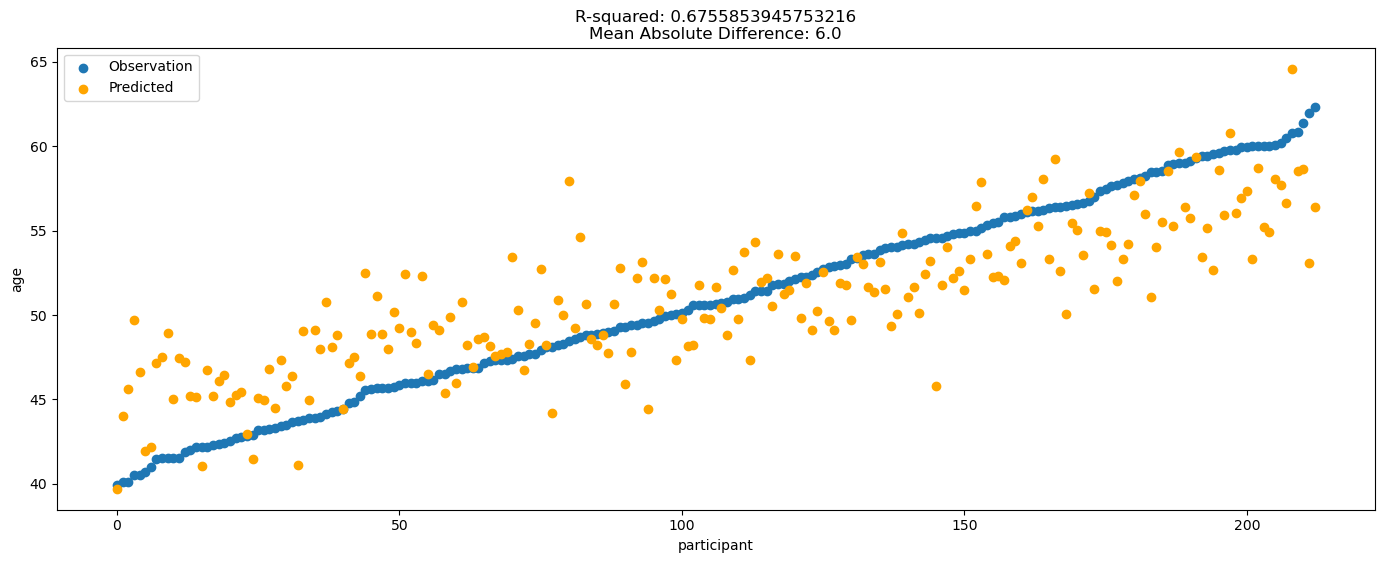

In [ ]:
# param_grid = {
#     'alpha':[0.01, 0.05, 0.1], 
#     'l1_ratio':[0.1, 0.5, 0.9], 
#     'max_iter': [5000]}


param_grid = {
    'alpha': [0.015], 
    'l1_ratio': [0.7], 
    'max_iter': [15000]
}


# Run hyperparameter search
dataloader = {
    'x_train': x_train_avg,
    'y_train': y_train_avg,
    'x_test': x_test_avg,
    'y_test': y_test_avg
}

results, model, predictions_avg = hyperparameter_search_EN(dataloader, param_grid, results, clock_name='avg')

validation_plot(y_test_avg, predictions_avg)

## Over-Represantation Analysis (ORA)

In [24]:
# Get coefficients from the model
coefficients = model.coef_
df = pd.DataFrame({'SeqIndex': shared_proteins, 'Coefficient': coefficients})
df.head()

,SeqIndex,Coefficient
0,seq.12694.28,-0.0
1,seq.18397.5,-0.0
2,seq.23241.27,-0.0
3,seq.20568.3,-0.0
4,seq.2979.8,-0.0


In [26]:
print(f"upregulated genes: {len(df[df.Coefficient > 0])}") 
print(f"downregulated genes: {len(df[df.Coefficient < 0])}") 
print(f"stable genes: {len(df[df.Coefficient == 0])}") 

upregulated genes: 240
downregulated genes: 231
stable genes: 7052


In [27]:
merged_df = pd.merge(analyte_conv, df, on='SeqIndex', how='inner')
merged_df.head()

,SeqIndex,EntrezGeneSymbol,Coefficient
0,seq.10000.28,CRYBB2,0.0
1,seq.10001.7,RAF1,0.0
2,seq.10003.15,ZNF41,0.0
3,seq.10006.25,ELK1,0.0
4,seq.10008.43,GUCA1A,0.0


In [39]:
genes_sorted = merged_df[merged_df['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False)

genes_sorted

,SeqIndex,EntrezGeneSymbol,Coefficient
4844,seq.3032.11,CGA|FSHB,4.023499
2035,seq.16890.37,ADAMTSL1,3.999370
3687,seq.22587.37,EPHA6,3.433434
6353,seq.7251.64,C1QTNF3,2.444975
5712,seq.5631.83,MLN,2.377350
...,...,...,...
3443,seq.2190.55,F11,0.009310
3402,seq.21802.53,NEIL1,0.008296
2320,seq.18202.22,CD37,0.007736
3361,seq.21732.78,UBE2Q1,0.006243


In [40]:
genes_sorted = genes_sorted.drop(["SeqIndex", "Coefficient"], axis=1)

In [41]:
genes_sorted.to_csv("genes_up_average.csv",index=False)

In [43]:
genes_sorted_down = merged_df[merged_df['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True)

genes_sorted_down

,SeqIndex,EntrezGeneSymbol,Coefficient
6908,seq.8841.65,CILP2,-5.075531
6623,seq.8080.24,MSMP,-3.447923
2140,seq.17447.52,SFRP4,-2.651560
2492,seq.18880.81,COL3A1,-2.119443
4327,seq.2475.1,KIT,-2.113840
...,...,...,...
6378,seq.7735.17,SERPINF1,-0.004787
72,seq.10391.1,ANGPTL3,-0.004441
5279,seq.4276.10,PEBP1,-0.003826
5047,seq.3457.57,POSTN,-0.003398


In [44]:
genes_sorted_down = genes_sorted_down.drop(["SeqIndex", "Coefficient"], axis=1)

In [46]:
genes_sorted_down.to_csv("genes_down_average.csv",index=False)